In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import cv2
import sys
import os
import glob
import re
from skimage.filters import gaussian
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import preprocessing
from pandas import DataFrame
import selectivesearch

sys.path.append(r"D:\Projects\LEGO Vision\Helpers")
import helpers
only_numbers = re.compile(r"\d+\.\d+")

In [4]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

In [5]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [6]:
def display_bounding_boxes(image, bounding_boxes, labels=None, scores=None):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image)
    for index, box in enumerate(bounding_boxes):
        x1, y1, x2, y2 = box
        rect = mpatches.Rectangle((x1, y1), abs(x2 - x1), abs(y2 - y1), fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        if labels and scores:
            ax.annotate(f"{labels[index]} {scores[index] * 100:.2f}%", (x1, y1))
        elif labels:
            ax.annotate(f"{labels[index]}", (x1, y1))

In [7]:
def resize_and_pad(img, width, height, pad_value=114):
    img_width = len(img[0])
    img_height = len(img)
    scale_w = img_width > img_height
    target_w = width
    target_h = height
    scale = None
    if scale_w:
        scale = float(width) / float(img_width)
        target_h = int(np.round(img_height * scale))
    else:
        scale = float(height) / float(img_height)
        target_w = int(np.round(img_width * scale))

    resized = cv2.resize(img, (target_w, target_h), 0, 0, interpolation=cv2.INTER_NEAREST)

    top = int(max(0, np.round((height - target_h) / 2)))
    left = int(max(0, np.round((width - target_w) / 2)))
    bottom = height - top - target_h
    right = width - left - target_w
    resized_with_pad = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                          cv2.BORDER_CONSTANT, value=[pad_value, pad_value, pad_value])
    return resized_with_pad, scale, (left, top, right, bottom)

In [90]:
image_path = r"D:\LEGO Vision Datasets\Detection\Natural Data_output\testImages\IMG_20181105_092359.jpg"
gt_bbox_path = r"D:\LEGO Vision Datasets\Detection\Natural Data_output\testImages\IMG_20181105_092359.bboxes.tsv"
gt_labels_path = r"D:\LEGO Vision Datasets\Detection\Natural Data_output\testImages\IMG_20181105_092359.bboxes.labels.tsv"

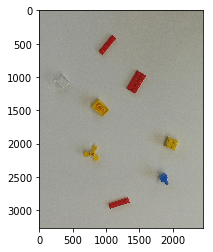

In [56]:
# resized = resize_and_pad(cv2.imread(image_path), width=1024, height=1024)[0]
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(image)

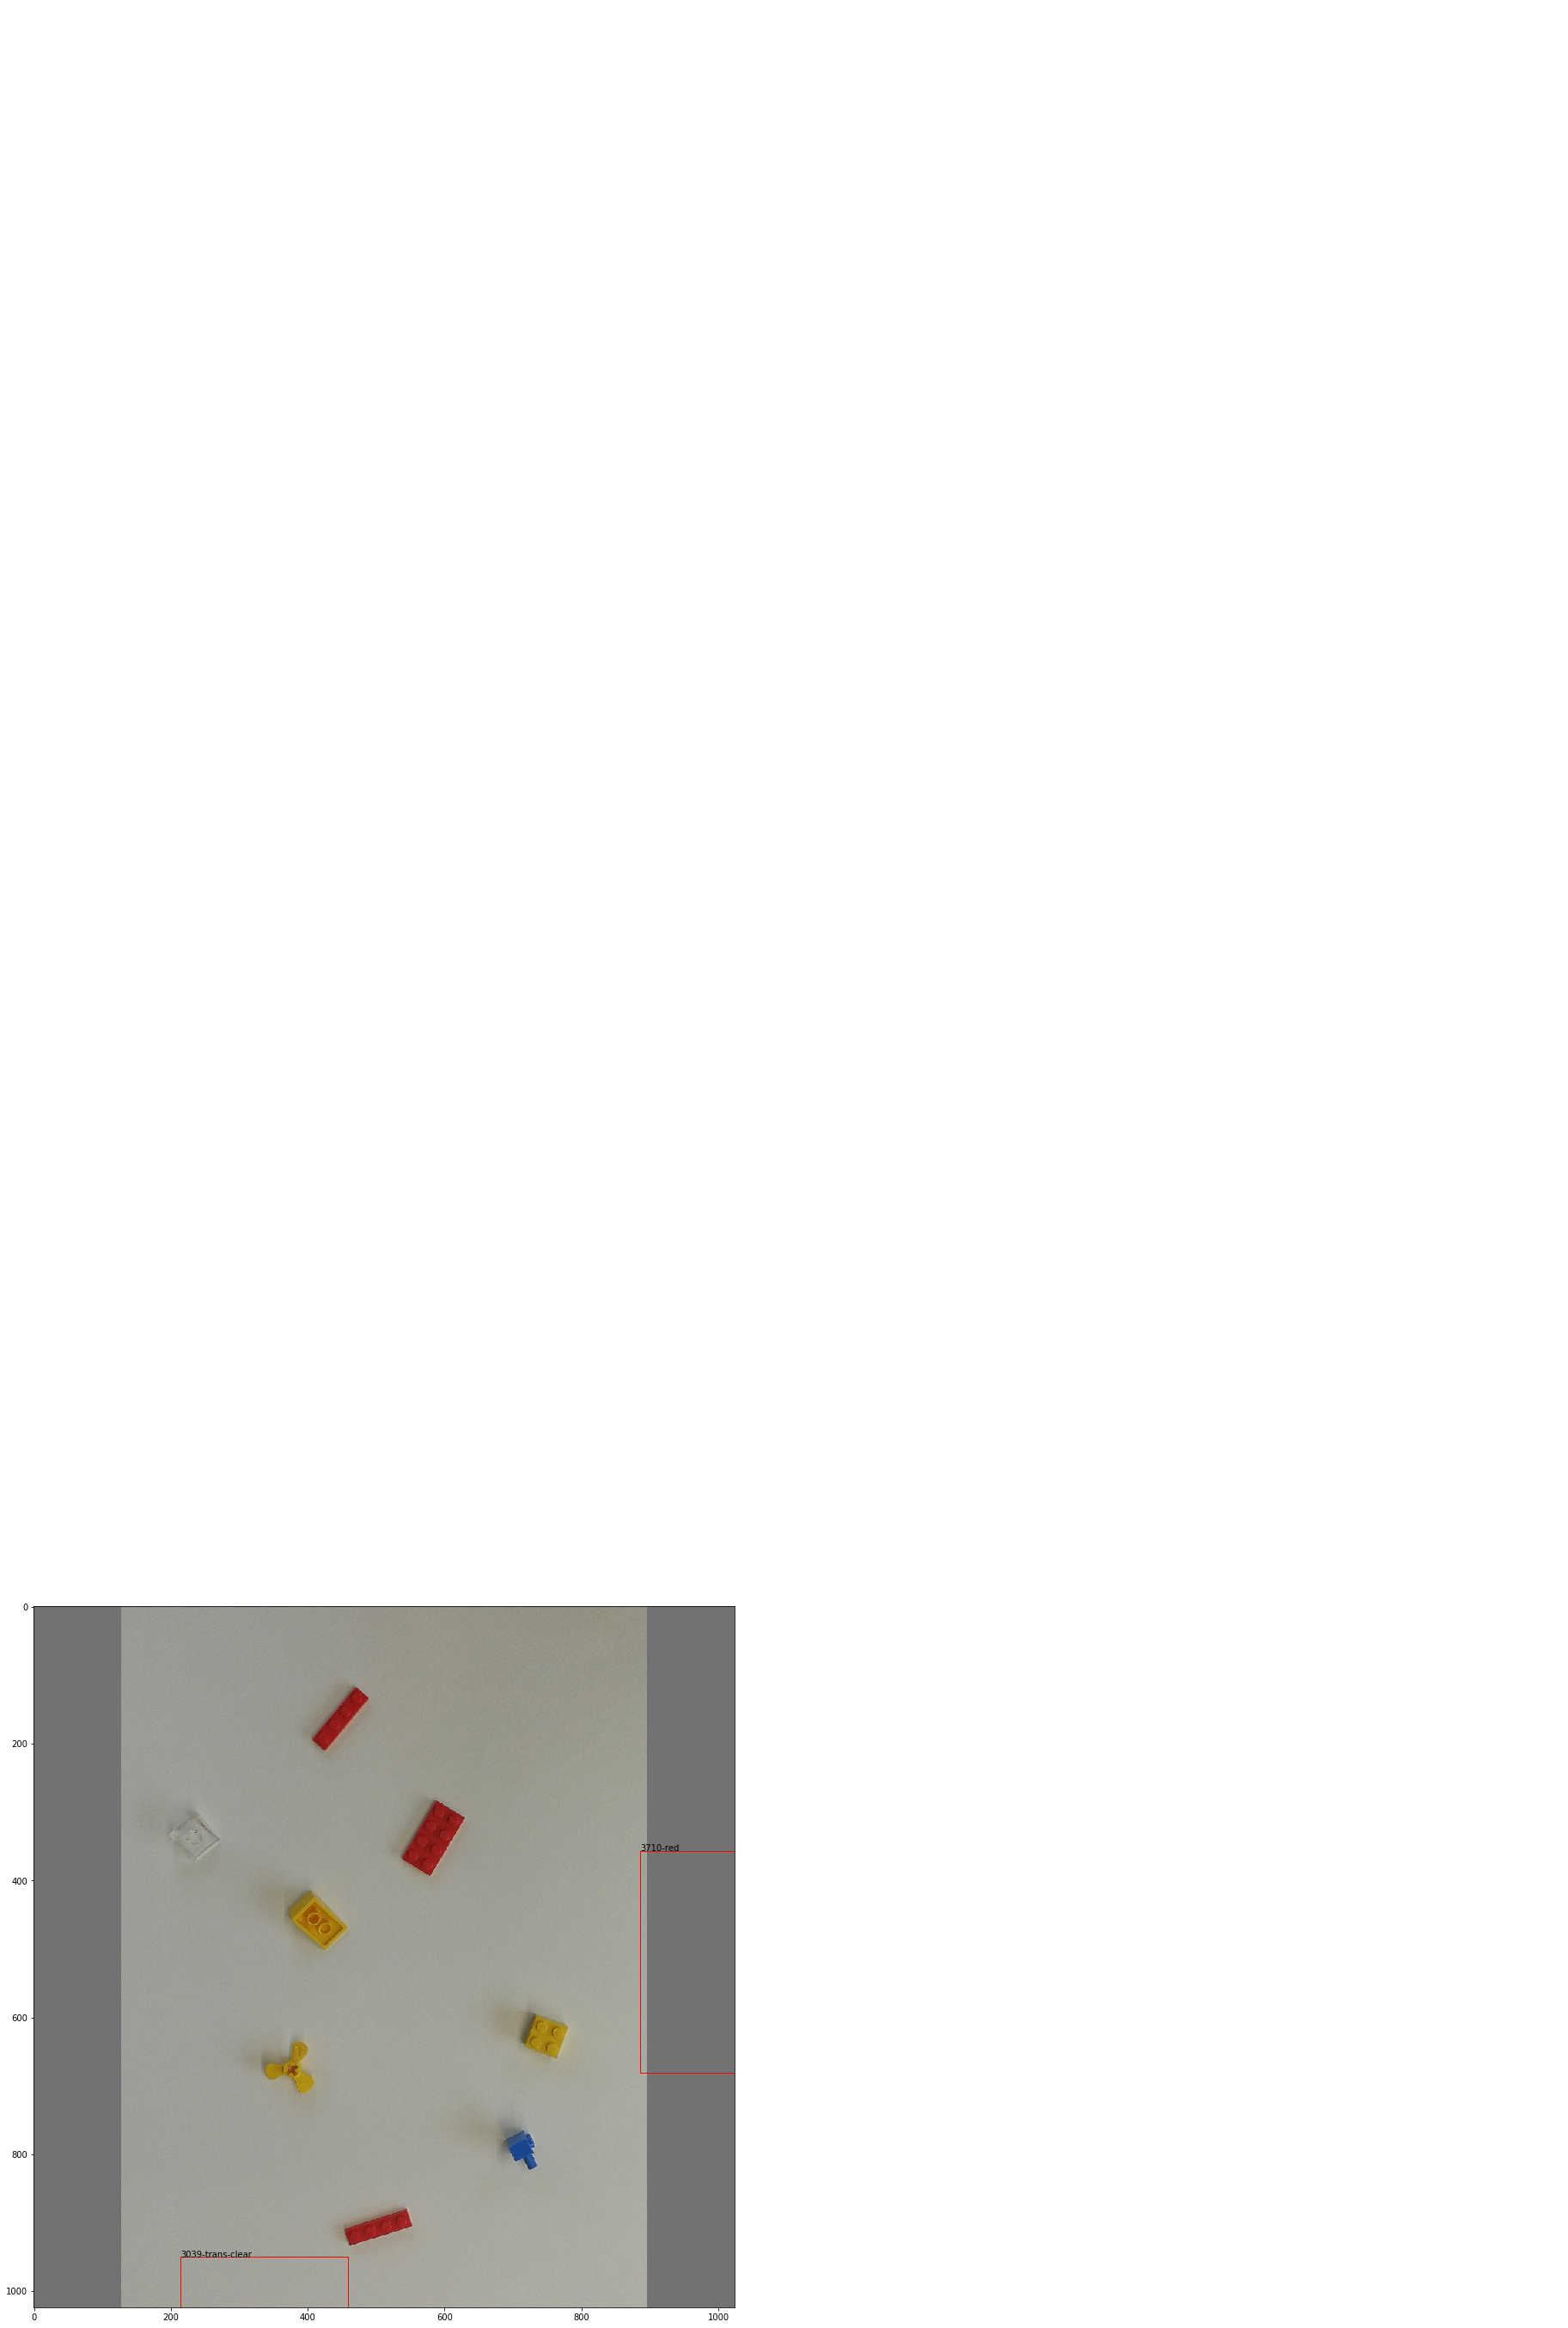

In [92]:
gt_bounding_boxes = list(map(lambda line: list(map(lambda string: float(string), re.findall(only_numbers, line))), open(gt_bbox_path).readlines()))
gt_labels = list(map(lambda line: line.strip('\n'), open(gt_labels_path).readlines()))
display_bounding_boxes(image, gt_bounding_boxes, gt_labels)

In [55]:
def calculate_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

def intersection_over_union_removal(ground_truth_bounding_boxes, predicted_bounding_boxes, threshold=0.5):
    above_threshold = []
    for gt_bbox in ground_truth_bounding_boxes:
        above_threshold.extend(list(filter(lambda boxB: calculate_intersection_over_union(gt_bbox, boxB)>threshold,
                                 predicted_bounding_boxes)))
    return above_threshold

In [58]:
image, scale, padding = resize_and_pad(image, width=1024, height=1024)

In [59]:
%%time
labels, regions = selectivesearch.selective_search(image, min_size=600, scale=400.0, sigma=1.5)

Wall time: 7.91 s


In [60]:
def w_h_to_x2_y2(box):
    x1, y1 = box[:2]
    x2, y2 = box[:2] + box[2:]
    return x1, y1, x2, y2

In [61]:
def x2_y2_to_w_h(box):
    x1, y1 = box[:2]
    w, h = box[2:] - box[:2]
    return x1, y1, w, h

In [62]:
selective_search_bboxes = list(map(lambda x: w_h_to_x2_y2(np.asarray(x['rect'])), regions))

In [63]:
def scale_bounding_box(box, scale=None, padding=None):
    assert isinstance(box, np.ndarray)
    if scale:
        box[np.array([0, 2])] = np.multiply(box[np.array([0, 2])], scale)
        box[np.array([1, 3])] = np.multiply(box[np.array([1, 3])], scale)
    left, top, right, bottom = padding
    box[0] = box[0] + left
    box[1] = box[1] + top
    box[2] = box[2] + right
    box[3] = box[3] + bottom
    return box

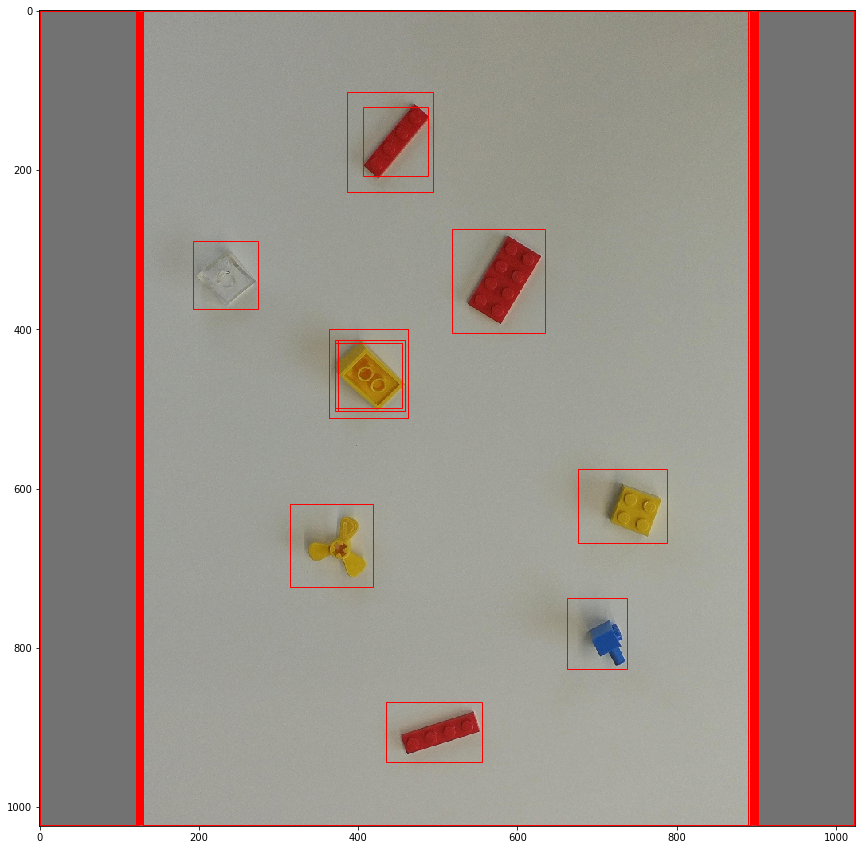

In [66]:
display_bounding_boxes(image=image, bounding_boxes=selective_search_bboxes)

In [75]:
remove_above_threshold = list(filter(lambda x: x2_y2_to_w_h(np.asarray(x))[2] < 500 and x2_y2_to_w_h(np.asarray(x))[3] < 500, selective_search_bboxes))

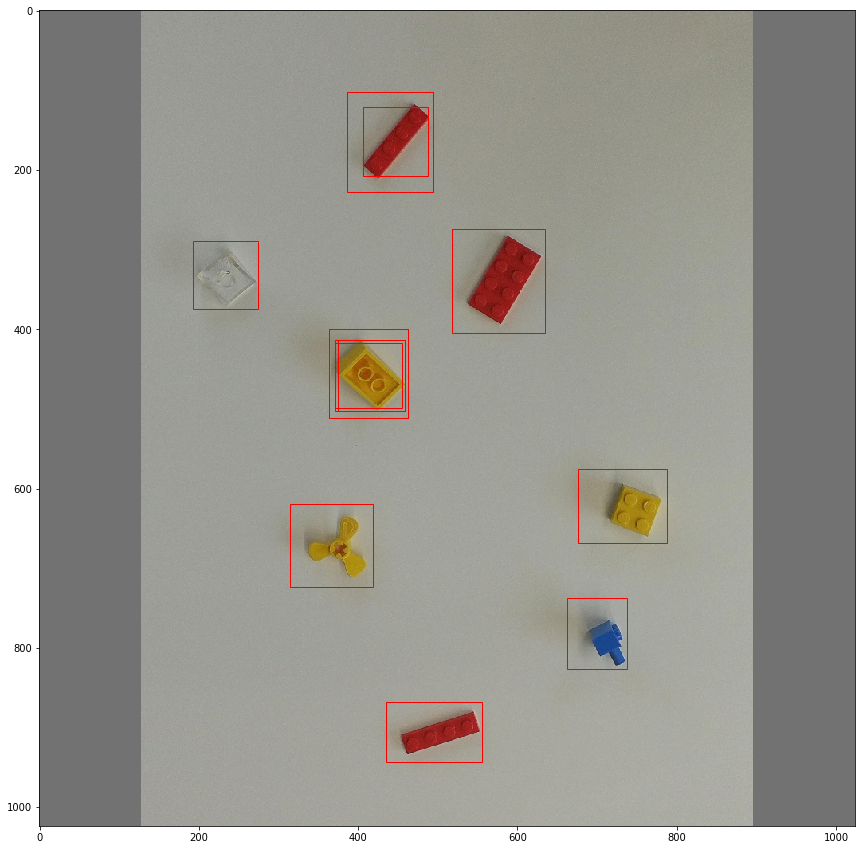

In [76]:
display_bounding_boxes(image, remove_above_threshold)

In [78]:
def cut_out_bounding_box(image, bounding_box, is_square=False):
    x1, y1, x2, y2 = bounding_box
    if is_square:
        window_size = abs(y2 - y1) if abs(y2 - y1) > abs(x2 - x1) else abs(x2 - x1)
        return image[y1:y1+window_size, x1:x1+window_size, :]
    return image[y1:y2, x1:x2, :]  

In [79]:
def preprocess(image, shape):    
    preproccesed = helpers.pipeline(image, shape=shape, smoothing=0.1, with_hog_attached=True,
                                    with_dominant_color_attached=True, pixels_per_cell=(shape[0]/8, shape[0]/8),
                                    cells_per_block=(8, 8), debug=True)
    preproccesed = preprocessing.scale(preproccesed, with_mean=False)   
    return preproccesed

def classify(image, classifier):
    prediction = classifier.predict_proba([image])
    return prediction[0]

In [80]:
classifier = joblib.load(r"D:\Projects\LEGO Vision\Classification\Final models\SVM\SVM-3200-256W.joblib")
shape = (256, 256)

In [153]:
classifier = joblib.load(r"D:\Projects\LEGO Vision\Classification\Final models\SVM\SVM-3200-128W.joblib")
shape = (128, 128)

In [156]:
classifier = joblib.load(r"D:\Projects\LEGO Vision\Classification\Final models\SVM\SVM-3200-64W.joblib")
shape = (64, 64)

In [81]:
label_lookup = sorted([line.split('\t')[0] for line in open(r"D:\LEGO Vision Datasets\Detection\Natural Data_output\class_map.txt").readlines()[1:]])
label_lookup

['2458-blue',
 '3003-yellow',
 '3020-red',
 '3039-trans-clear',
 '3298-yellow',
 '3710-red',
 '6041-yellow']

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6181664133957898


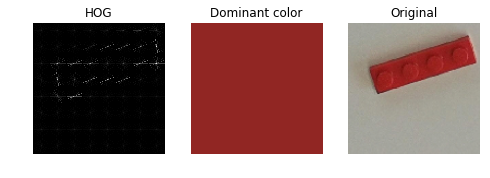

0.0
0.0
0.0
0.6311813566345169


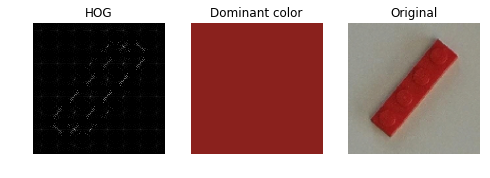

0.8324253913300332


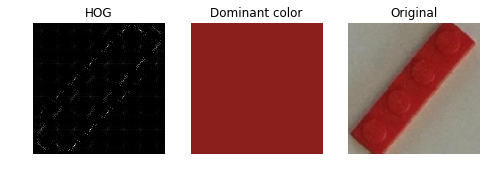

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6311813566345169


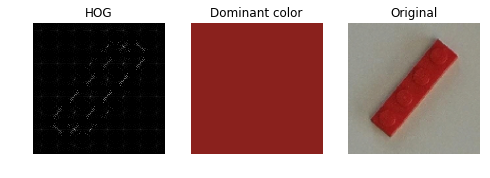

0.0
0.0
0.0
0.7543740584544644


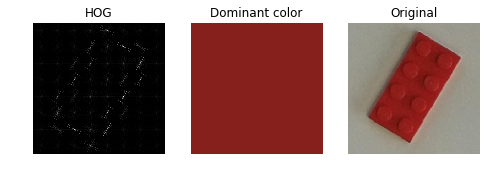

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47281788345750336


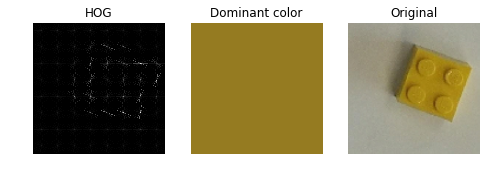

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.43002534249110735


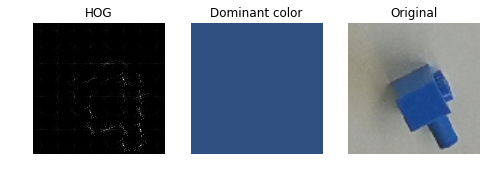

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6041342550091928


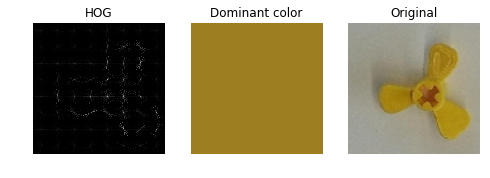

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8192829119178588


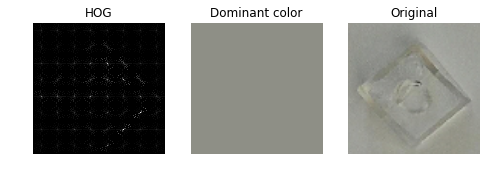

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8004133573169913


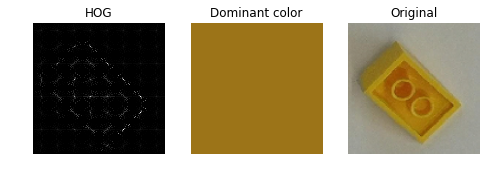

0.8472797285201908


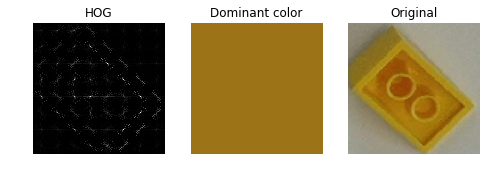

0.772294377869502


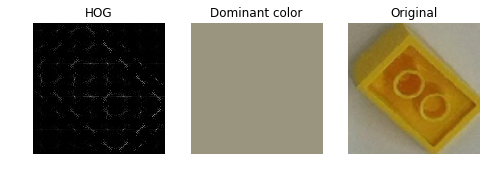

0.0
0.0
0.0
0.0
0.8768359981197325


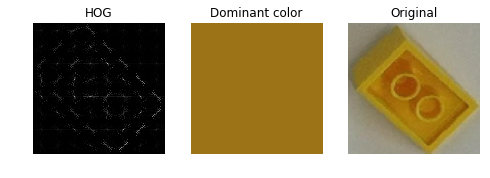

0.0
0.8004133573169913


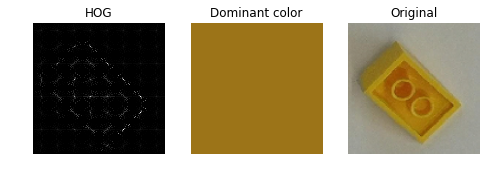

In [101]:
scores = []
labels = []
actual = []
for idx, gt_bbox in enumerate(gt_bounding_boxes):
    gt_bbox = scale_bounding_box(box=np.array(gt_bbox), scale=scale, padding=padding)
    for bounding_box in remove_above_threshold:
        print(bb_intersection_over_union(gt_bbox, bounding_box))
        if bb_intersection_over_union(gt_bbox, bounding_box) > 0.4:
            sub_image = cut_out_bounding_box(image, bounding_box, is_square=True)
            prediction = classify(preprocess(sub_image, shape), classifier)
            scores.append(max(prediction))
            labels.append(label_lookup[prediction.argmax(axis=0)])
            actual.append(gt_labels[idx])

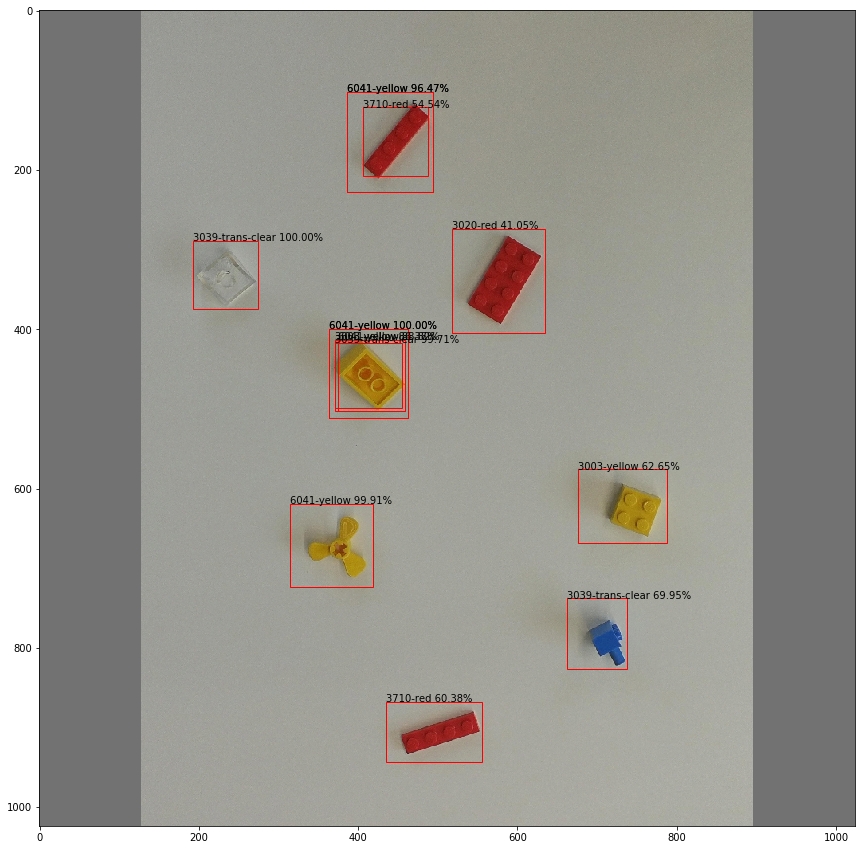

In [83]:
display_bounding_boxes(image, remove_above_threshold, labels, scores)

In [124]:
import itertools
from sklearn.metrics import average_precision_score
def average_precision_per_class(actual, predicted):
    average_precision_per_class = dict()
    for _class, actual_predicted_list in itertools.groupby(zip(actual, predicted), lambda x: x[0]):
        print(sorted(actual_predicted_list, key=lambda x: x[1]['score'], reverse=True))
        average_precision_per_class[_class] = average_precision_score(actual, [pred['label'] for pred in predicted])
    return average_precision_per_class

In [86]:
predicted = [dict(label=label, score=score) for label, score in zip(labels, scores)]

[{'label': '6041-yellow', 'score': 0.9646935155571096},
 {'label': '3710-red', 'score': 0.5453908254506897},
 {'label': '3020-red', 'score': 0.410543350278096},
 {'label': '3039-trans-clear', 'score': 0.9999998266875345},
 {'label': '6041-yellow', 'score': 0.9999995138570422},
 {'label': '6041-yellow', 'score': 0.8882455168355328},
 {'label': '3039-trans-clear', 'score': 0.9970938241854077},
 {'label': '3003-yellow', 'score': 0.6264621561590327},
 {'label': '6041-yellow', 'score': 0.9991352018130983},
 {'label': '3039-trans-clear', 'score': 0.6994910880170653},
 {'label': '3710-red', 'score': 0.6038329321022973},
 {'label': '3003-yellow', 'score': 0.8636840830439325},
 {'label': '6041-yellow', 'score': 0.9646866469957447},
 {'label': '6041-yellow', 'score': 0.9999995137825658}]